In [1]:
#check erosion/deposition inside meadows
#not using min/max hcan with interval of certain days
#instead: mean daily volume change while hcan is above or below certain value.
#--> run SyltRomo/eroded_vol_intertidal_nochange_sav_two_hcan.py first
from netCDF4 import Dataset
import numpy as  np
import matplotlib.pyplot as plt

import math
import glob
import os.path
import sys
sys.path.insert(0, '/home/g/g260204/tools/python_skripts/SchismUtils/')
from schism_utils import read_data, sort_files
import h5py
import os.path

from matplotlib import rcParams
rcParams['figure.dpi'] = 300

import matplotlib as mpl
mpl.rc('hatch', color='k', linewidth=1)

In [2]:
p5pat = 'work/gg0877/g260204/data/picklefiles'
study = 'srm02x3x'
figname = 'srm02x3x'
hcanlim1 = 0.1
hcanlim2 = 0.02
h5pypath= '/work/gg0877/g260204/data/pickle_files/'
run_labels=['no sg','stat sg (ref)','var sg (ref)','stat sg (int)','var sg (int)']
colors =  ['tab:blue','tab:orange','tab:green','orangered','darkgreen']#['tab:blue','midnightblue','gold','tab:orange','wheat','tan','peru','tab:green','lightgreen','darkseagreen','darkgreen','teal']
varsgrun = 'srm024'
runs=['srm020','srm026','srm024','srm035','srm036']
heights = ['nocan','midcan','highcan']
plotpat = '/work/gg0877/g260204/sim_data/SR5yr/plots/plots/'

2010 min [ 42 156] max [207 350]
2011 min [ 22 148] max [211 338]
2012 min [ 17 155] max [222 343]
2013 min [ 29 156] max [215 339]
2014 min [ 20 147] max [200 348]
2015 min [ 15 159] max [221 344]


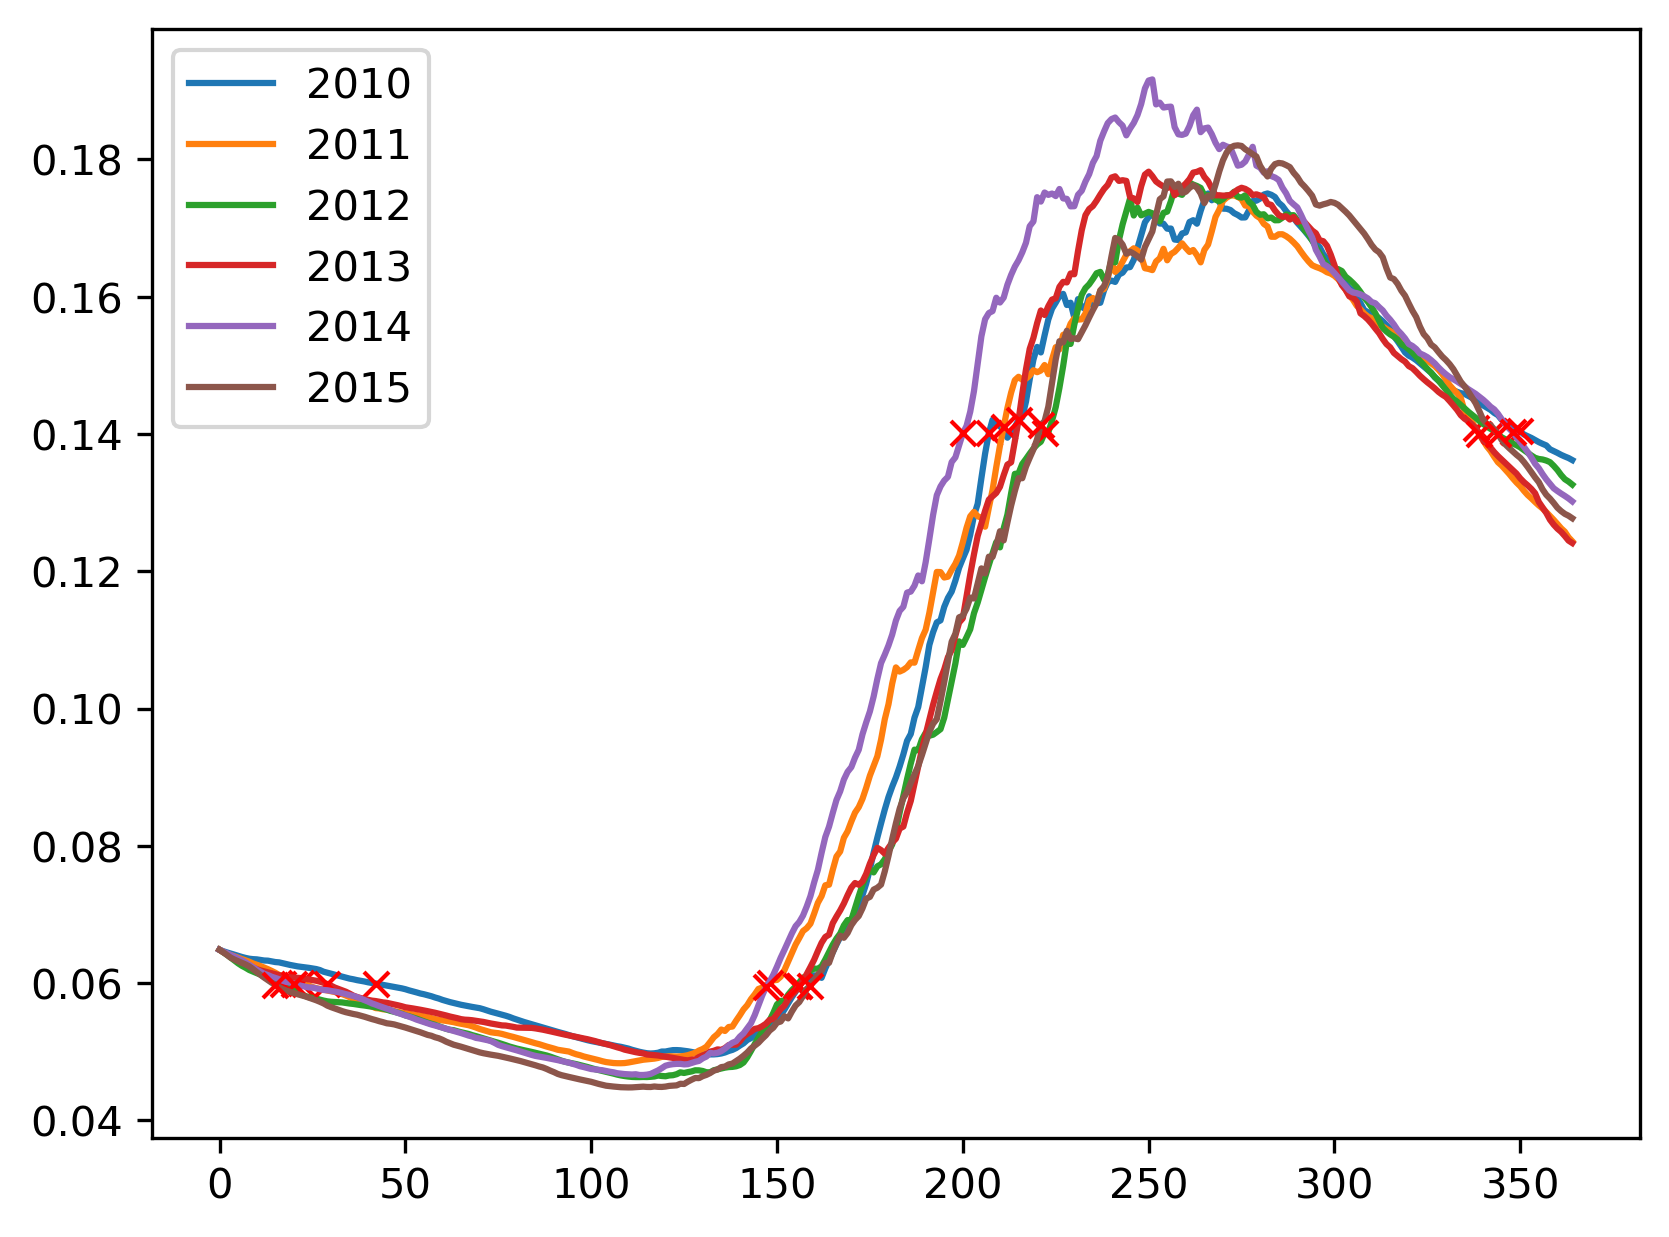

In [3]:

#sim x years x hcan x season
s_year=2010
e_year=2016
all_erovol = np.zeros((len(runs),e_year-s_year,3,2))
all_last =  np.zeros((len(runs),e_year-s_year,3,2))

for year in range(s_year,e_year):
    fname = h5pypath + study + '_'+str(year)+'_intertidal_' + str(hcanlim1) + '_' + str(hcanlim2) + '.hdf5'
    f = h5py.File(fname,'r')
    #days hcan above threshold of 14 cm!
    hcan = np.array(f[varsgrun +'_'+str(year)+'_hcan_highcan'])
    imax = np.where(hcan>0.14)[0][[0,-1]]
    imin = np.where(hcan<0.06)[0][[0,-1]]
    plt.plot(hcan,label=str(year))
    plt.plot([imin],hcan[[imin]],'xr')
    plt.plot([imax],hcan[[imax]],'xr')
    minmax = [imin,imax]
    print(year, 'min',imin,'max',imax)
    for run in range(0,len(runs)):
        for h in range(0,len(heights)):
            for s in range(0,2):
                #start
                varname = runs[run]+'_'+str(year)+'_'+heights[h]
                #print(varname, f[varname][-1])
                diff = -(f[varname][minmax[s][1]]-f[varname][minmax[s][0]])/(minmax[s][1]-minmax[s][0]) #invert because positive downward
                #write diff to array
                all_last[run,year-s_year,h,s] = -f[varname][-1]
                all_erovol[run,year-s_year,h,s]=diff
   
    plt.legend()
    #df = pd.DataFrame()
    #for title in f.keys():
    #    df[title]=np.array(h5py.File(h5pypath)[title])
    #f.close()

In [4]:
#mean over years
#sim x hcan x season
fname = plotpat + figname +'/'+ study + '_'+str(year)+'_intertidal_' + str(hcanlim1) + '_' + str(hcanlim2) + '_volchange.txt'
ffile = open(fname,"w")
mean_erovol = np.mean(all_erovol,1)
rmsd_erovol = np.sqrt(np.var(all_erovol,1))
mean_last = np.mean(all_last,1)
rmsd_last = np.sqrt(np.var(all_last,1))

ffile.write('total volume change in areas:')
for r in range(0,len(runs)):
    ffile.write('\n' + run_labels[r] +': [low mid high all]' + str(mean_last[r,:,1]) + str(np.sum(mean_last[r,:,1])))

ffile.write('\n error total volume change in areas:')
for r in range(0,len(runs)):
    ffile.write('\n' + run_labels[r] + ': [low mid high all]'+str(rmsd_last[r,:,1])+str( np.sum(rmsd_last[r,:,1])))

/tmp/ipykernel_721309/1796946417.py:29: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


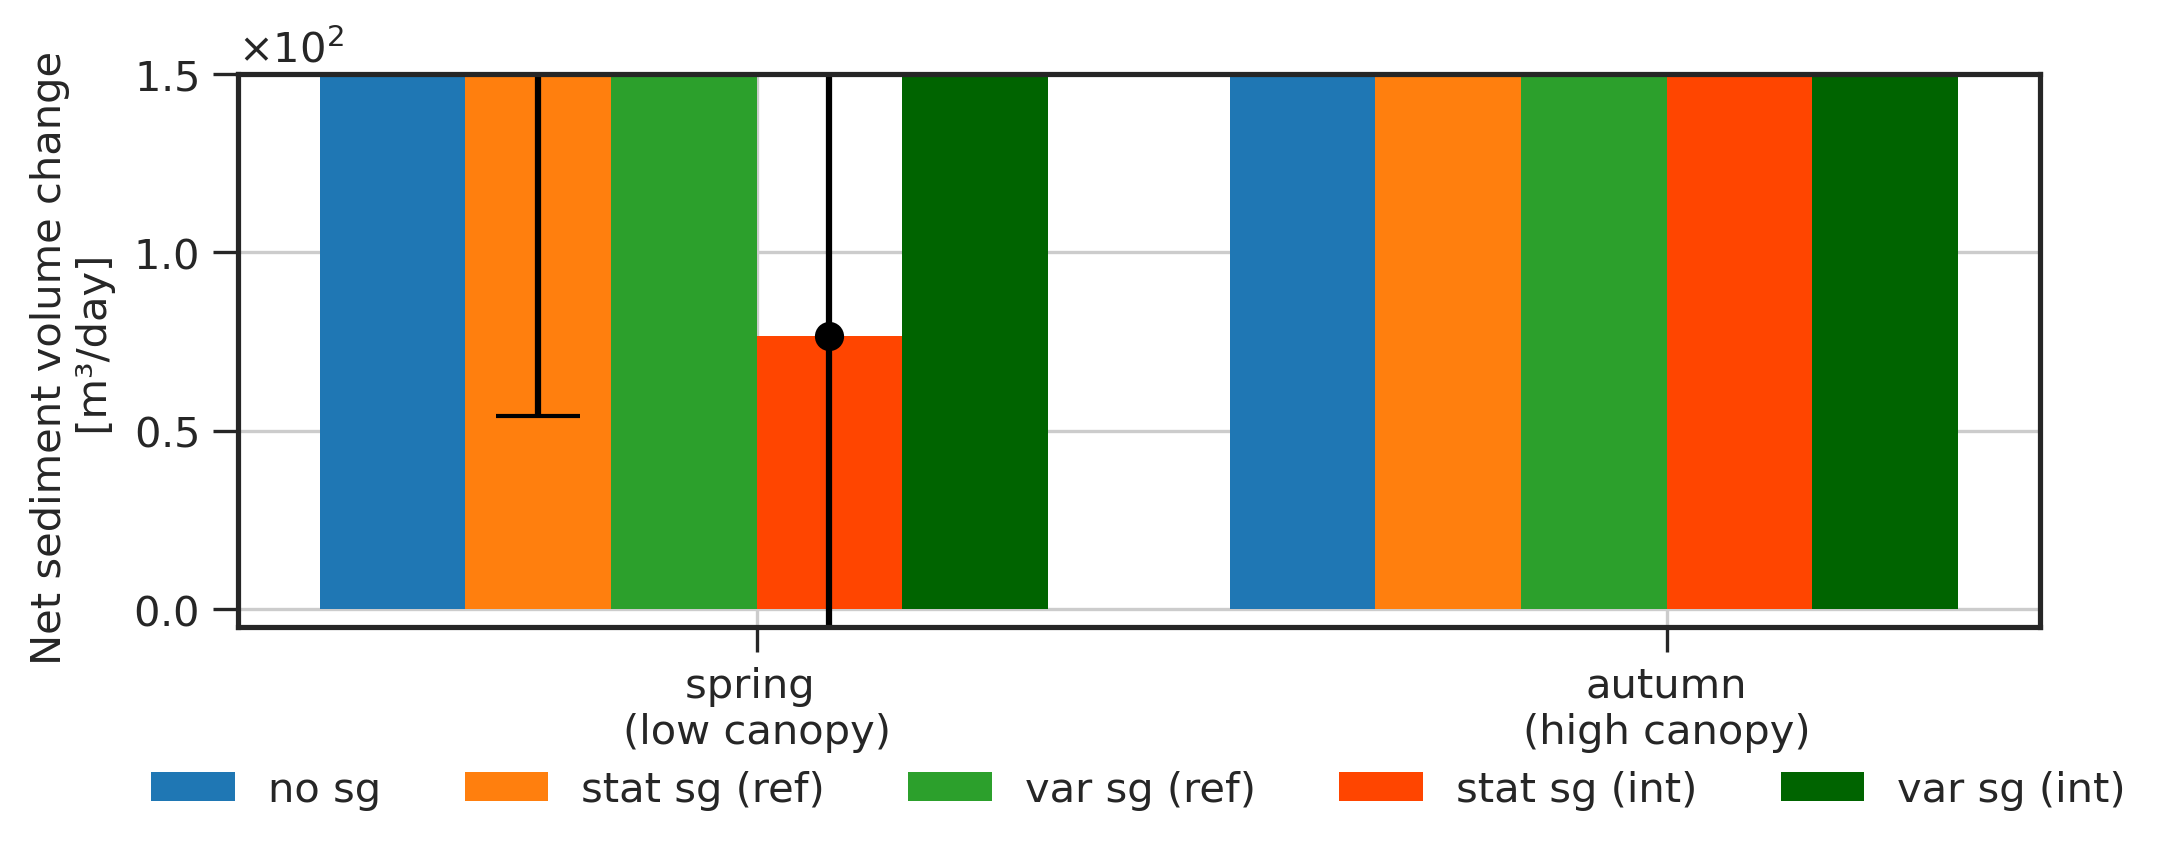

In [5]:
#all in one and pretty
#outside meadows

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width =(1-0.2)/len(runs)
multiplier = -1.5

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3.5)
fig.set_figwidth(7)
ax.grid()
for run in range(0,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,mean_erovol[run,0,:],width,label=run_labels[run],color = colors[run])
    ax.errorbar(x+offset,mean_erovol[run,0,:],yerr=rmsd_erovol[run,0,:],fmt='o',color='k',capsize = 10)
    multiplier +=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Net sediment volume change \n [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
ax.set_ylim([-5,150])
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')
plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,box.width, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=5)

plt.savefig(plotpat+ figname + '/daily_volume_change_intertidal_nocan_seasons_'+ heights[0]+'_all.png')
    

[39.07830315 14.78244872]
[13.98187408  7.85840761]
[28.26524018 10.14582615]
[14.12254254 13.65110178]
[24.39252205  7.85690398]


/tmp/ipykernel_721309/557763159.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


[  3.48887022 -17.65490928   6.22825628  23.72621514 -91.11399799
 -50.90002961]


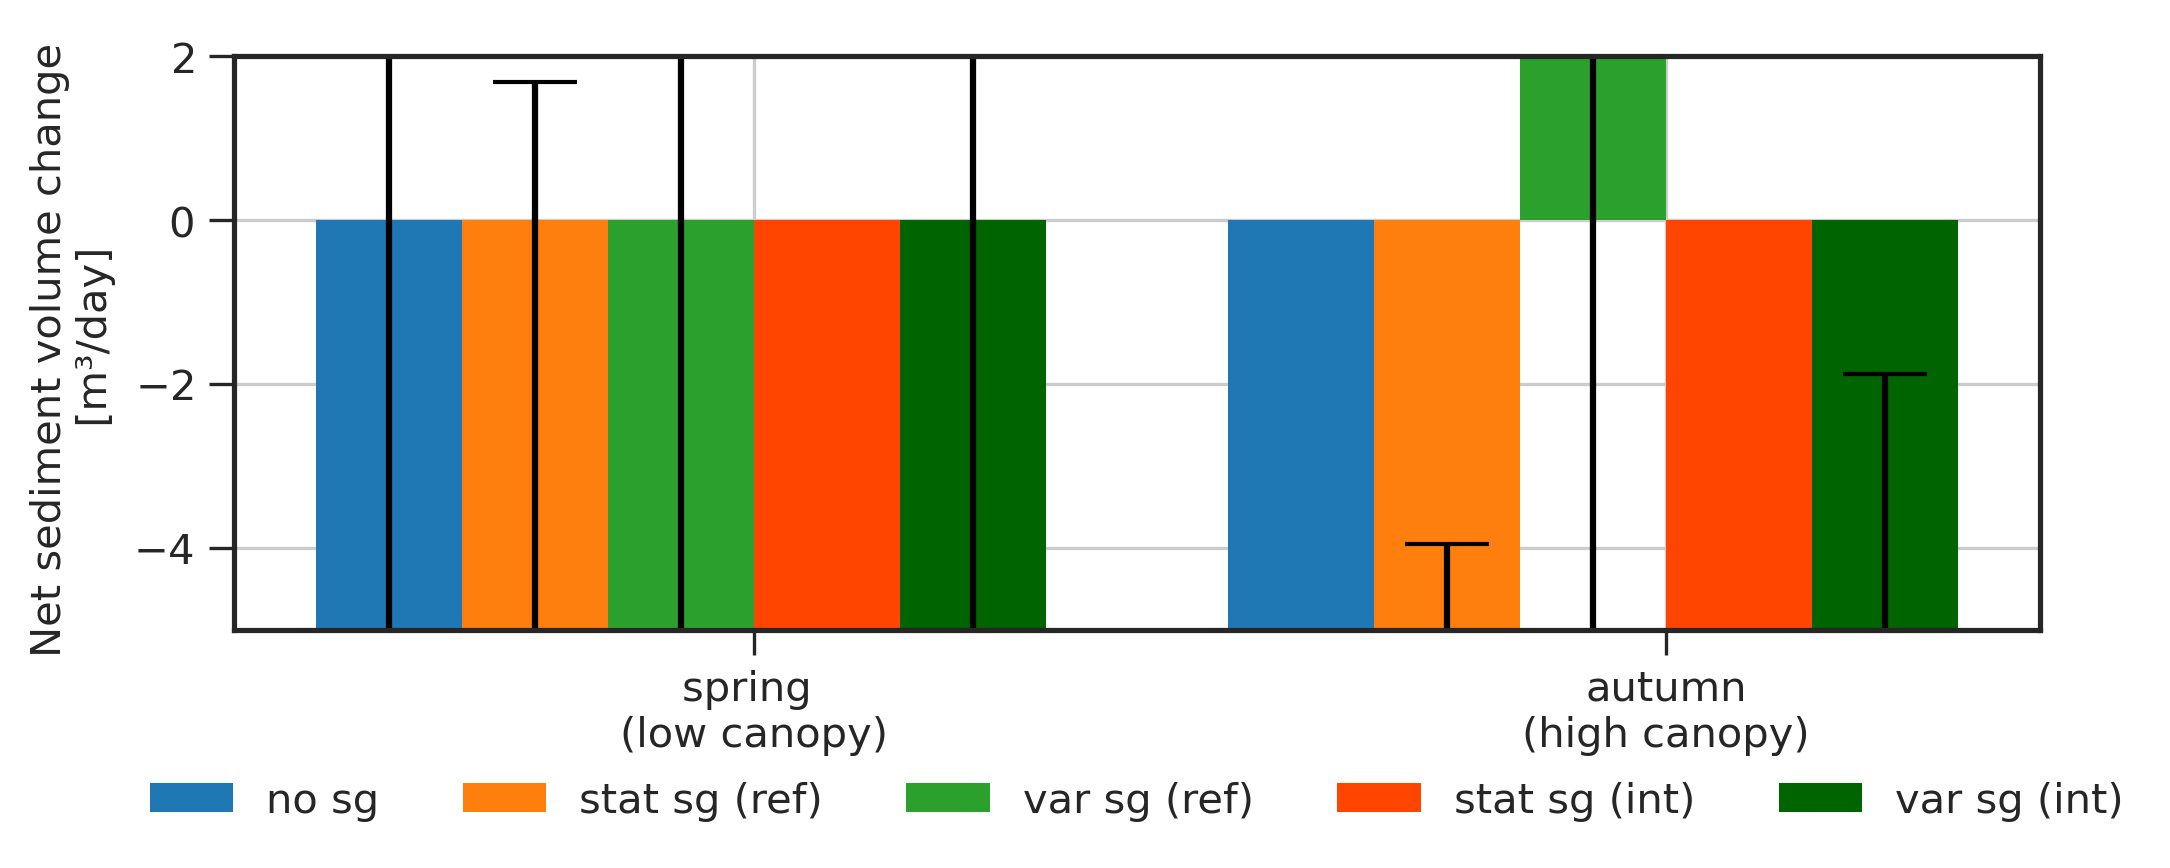

In [6]:
#all in one and pretty
#inside meadows, medium canopy height

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1.5

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3.5)
fig.set_figwidth(7)
ax.grid()
for run in range(0,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,mean_erovol[run,1,:],width,label=run_labels[run],color = colors[run])    
    ax.errorbar(x+offset,mean_erovol[run,1,:],yerr=rmsd_erovol[run,1,:],fmt='o',color='k',capsize = 10)
    multiplier +=1
    print(rmsd_erovol[run,1,:])
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Net sediment volume change \n [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
ax.set_ylim([-5,2])
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')

plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,box.width, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=5)
plt.savefig(plotpat+ figname + '/daily_volume_change_intertidal_nocan_seasons_'+ heights[1]+'_all.png')
print(all_erovol[0,:,1,0])


[-5.91420138 -8.46932321] [6.27231401 5.69431603]
[-1.82006931 -2.95346692] [2.76519132 2.29934713]
[-4.16100142 -3.11205619] [5.18993137 2.19334325]
[-1.37332615 -2.27763464] [2.18683125 2.39501045]
[-4.13883615 -0.16087034] [4.32428378 0.57734218]


/tmp/ipykernel_721309/1333297295.py:30: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


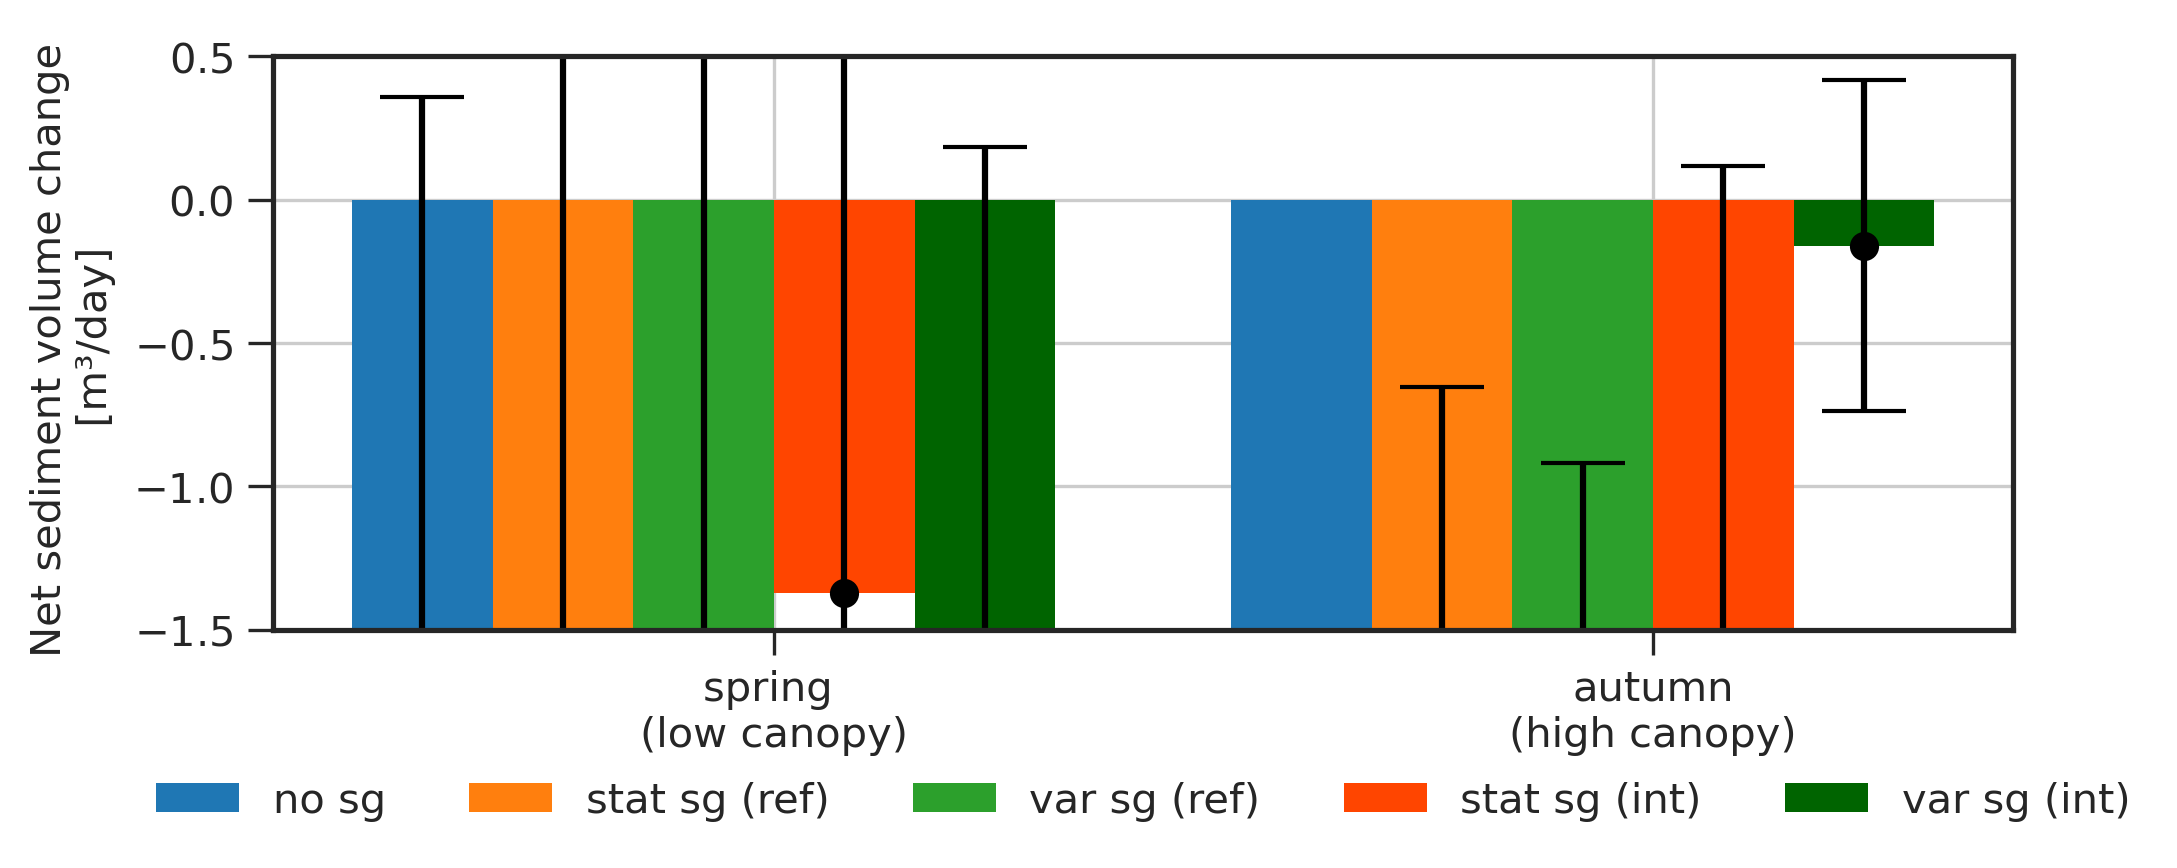

In [7]:
#all in one and pretty
#inside meadows, high canopy height

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1.5

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3.5)
fig.set_figwidth(7)
ax.grid()
for run in range(0,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,mean_erovol[run,2,:],width,label=run_labels[run],color=colors[run])
    ax.errorbar(x+offset,mean_erovol[run,2,:],yerr=rmsd_erovol[run,2,:],fmt='o',color='k',capsize = 10)
    multiplier +=1
    print(mean_erovol[run,2,:],rmsd_erovol[run,2,:])
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Net sediment volume change \n [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
ax.set_ylim([-1.5,0.5])
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')
plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,box.width, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=5)
plt.savefig(plotpat+ figname + '/daily_volume_change_intertidal_nocan_seasons_'+ heights[2]+'_all.png')
    

[ 355.80401463 1048.61279552] [244.96265248 310.95664616] no sg
[239.63908652 948.72636769] [216.52053556 292.59353116] stat sg (ref)
[ 349.70286683 1053.45499744] [234.33488237 297.37056676] var sg (ref)
[ 55.24740285 639.35286691] [132.87177821 338.97778725] stat sg (int)
[ 288.43490807 1711.94612427] [192.28133695 374.00818921] var sg (int)


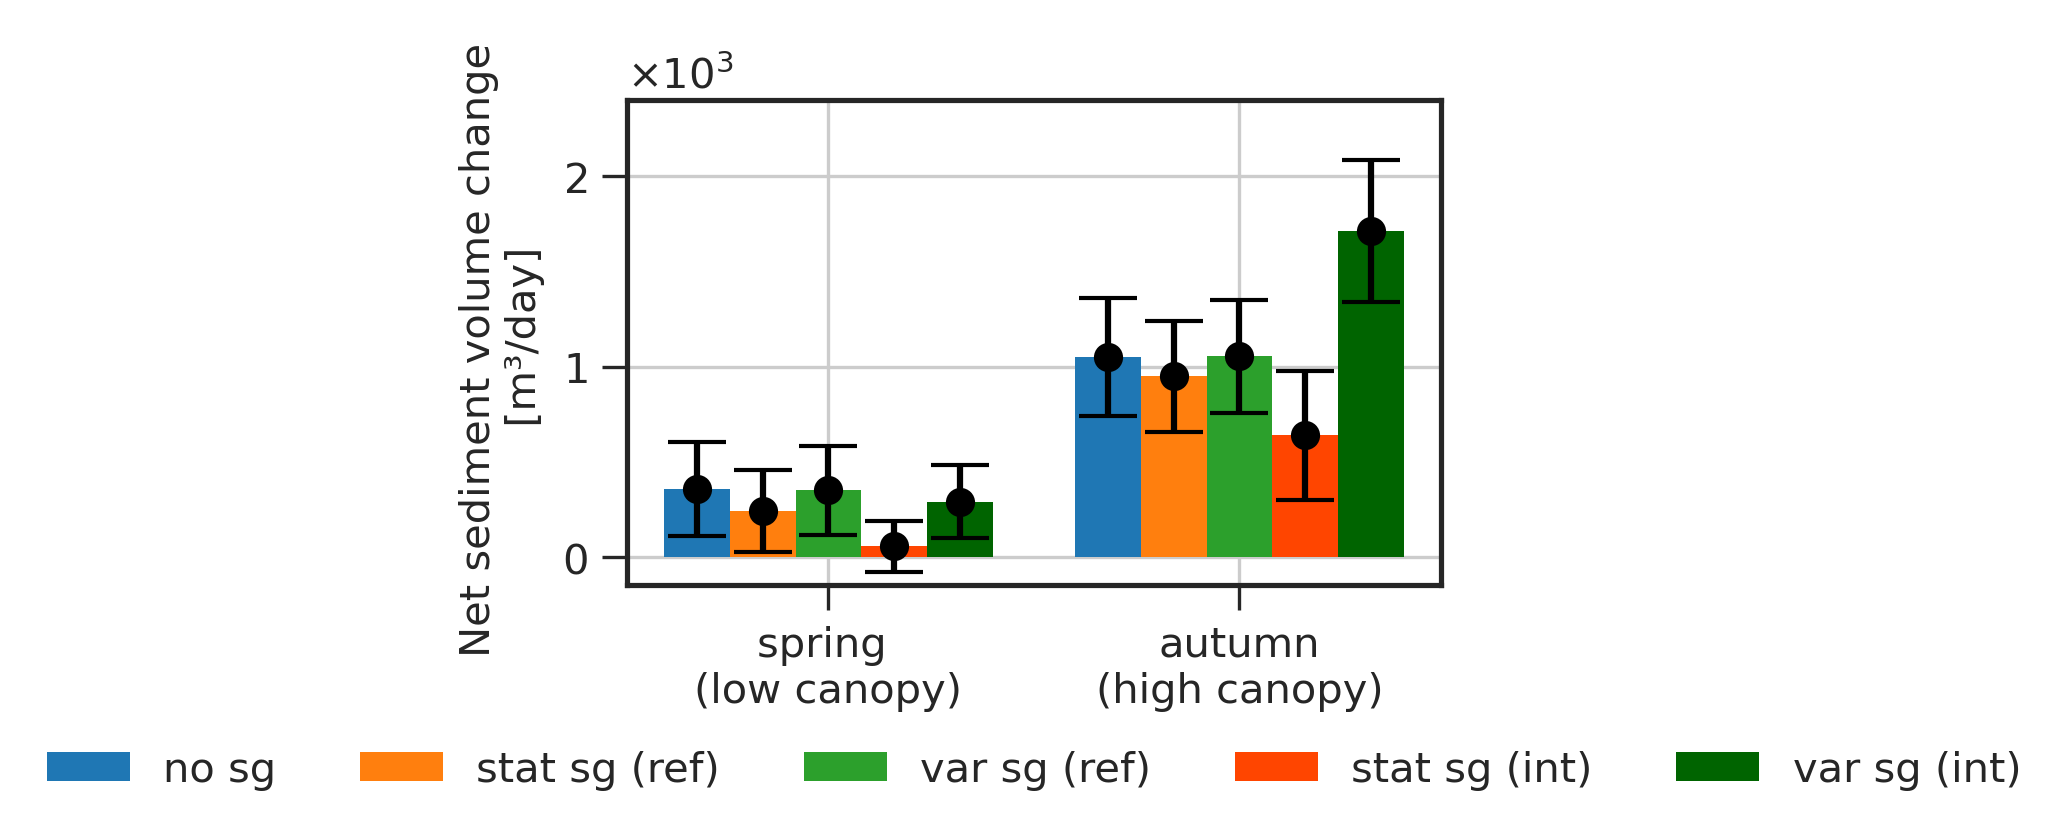

In [14]:
#all in one and pretty
#all intertidal

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3)
fig.set_figwidth(5)
ax.grid()
for run in range(0,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,np.sum(mean_erovol,1)[run,:],width,label=run_labels[run],color=colors[run])
    ax.errorbar(x+offset,np.sum(mean_erovol,1)[run,:],yerr=np.sum(rmsd_erovol,1)[run,:],fmt='o',color='k',capsize = 7)
    multiplier +=1
    print(np.sum(mean_erovol,1)[run,:],np.sum(rmsd_erovol,1)[run,:],run_labels[run])
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Net sediment volume change \n [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
ax.set_ylim([-150,2400])
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')
#plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0 + box.width*0.2, box.y0 + box.height * 0.3,box.width*0.7, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), fancybox=True, ncol=5)

plt.savefig(plotpat+ figname + '/daily_volume_change_intertidal_allint_seasons_'+ heights[2]+'_all.png')
    

In [9]:
#statistics spring:
ffile.write('\n\n statistics spring')
ffile.write('\n\n outside meadows')
for r in range(0,len(runs)):
    ffile.write('\n' + run_labels[r]+' total sed volume chage:'+ str(mean_erovol[r,0,0]))
    ffile.write('\n perc. change '+run_labels[r]+':'+ str((mean_erovol[r,0,0]-mean_erovol[0,0,0])/mean_erovol[0,0,0]))

ffile.write('\n\n inside meadows (mid canopy height)')
for r in range(0,len(runs)):
    ffile.write('\n'+ run_labels[r]+' total sed volume chage:'+ str(mean_erovol[r,1,0]))
    ffile.write('\n perc. change ' + run_labels[r] + ':' + str((mean_erovol[r,1,0]-mean_erovol[0,1,0])/mean_erovol[0,1,0]))

ffile.write('\n\n inside meadows (high canopy height)')
for r in range(0,len(runs)):
    ffile.write('\n' + run_labels[r] +' total sed volume chage:' +str(mean_erovol[r,2,0]))
    ffile.write('\n perc. change' + run_labels[r] + ':' +  str((mean_erovol[r,2,0]-mean_erovol[0,2,0])/mean_erovol[0,2,0]))

ffile.write('\n\n inside meadows (total)')
for r in range(0,len(runs)):
    ffile.write('\n' + run_labels[r] + ' total sed volume chage:' + str(mean_erovol[r,1,0]+mean_erovol[r,2,0]))
    ffile.write('\n perc. change ' + run_labels[r] + ':' + str( ((mean_erovol[r,1,0]+mean_erovol[r,2,0]) -(mean_erovol[0,1,0]+mean_erovol[0,2,0]))/ (mean_erovol[0,1,0]+mean_erovol[0,2,0])))

In [10]:
#statistics autumn:

ffile.write('\n\n statistics autumn')
ffile.write('\n\n outside meadows')
for r in range(0,len(runs)):
    ffile.write('\n' + run_labels[r]+' total sed volume chage:'+ str(mean_erovol[r,0,1]))
    ffile.write('\n perc. change '+run_labels[r]+':'+ str((mean_erovol[r,0,1]-mean_erovol[0,0,1])/mean_erovol[0,0,1]))

ffile.write('\n\n inside meadows (mid canopy height)')
for r in range(0,len(runs)):
    ffile.write('\n'+ run_labels[r]+' total sed volume chage:'+ str(mean_erovol[r,1,1]))
    ffile.write('\n perc. change ' + run_labels[r] + ':' + str((mean_erovol[r,1,1]-mean_erovol[0,1,1])/mean_erovol[0,1,1]))

ffile.write('\n\n inside meadows (high canopy height)')
for r in range(0,len(runs)):
    ffile.write('\n' + run_labels[r] +' total sed volume chage:' +str(mean_erovol[r,2,1]))
    ffile.write('\n perc. change' + run_labels[r] + ':' +  str((mean_erovol[r,2,1]-mean_erovol[0,2,1])/mean_erovol[0,2,1]))

ffile.write('\n\n inside meadows (total)')
for r in range(0,len(runs)):
    ffile.write('\n' + run_labels[r] + ' total sed volume chage:' + str(mean_erovol[r,1,1]+mean_erovol[r,2,1]))
    ffile.write('\n perc. change ' + run_labels[r] + ':' + str( ((mean_erovol[r,1,1]+mean_erovol[r,2,1]) -(mean_erovol[0,1,1]+mean_erovol[0,2,1]))/ (mean_erovol[0,1,1]+mean_erovol[0,2,1])))
ffile.close()

In [11]:
rmsd_erovol[2,2,:]


array([5.18993137, 2.19334325])